### This the Python code for the paper:
#Analyzing and Optimizing the Distribution of Blood Lead Level Testing for Children in New York City
The analysis include:
- Basic analysis to showcase the differemce in terms of rates per neighborhood
- CLustering based on risk profile and vulnerability
- Projecting the cases detected next year using the current testing policy
- Perform the optimization and project the number of cases detected with the new distribtuion

**PS: The results of the study are better summarized in the paper**

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Directly read the CSV files
df = pd.read_csv('R5_rates.csv')
tests = pd.read_csv('tests.csv')
# Make a copy of df to work with
df2 = df.copy()
# Directly read the GeoJSON file for mapping
geo_json_data = gpd.read_file('UHF42.geo.json')


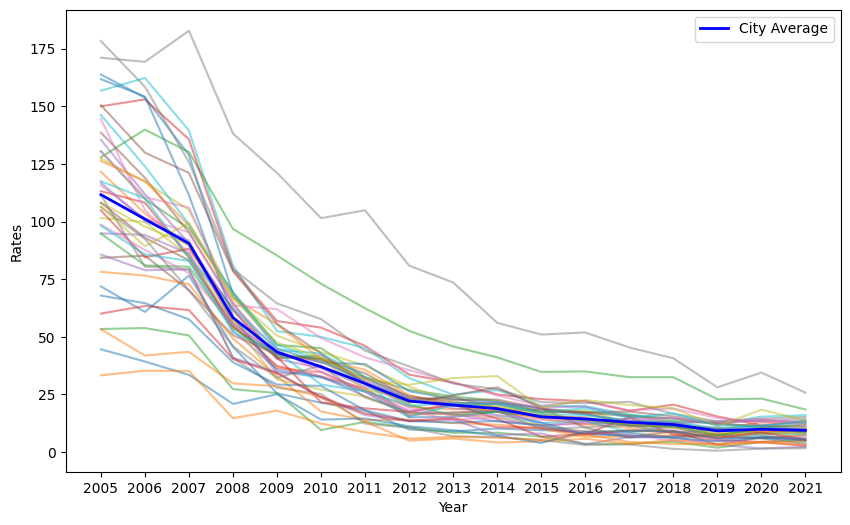

In [ ]:
# PLot the yearly average with the average for each neighborhood
years = [str(year) for year in range(2005, 2022)]
# Calculate the average for each year
average_per_year = df[years].mean()
# First iteration using values from 'df'
plt.figure(figsize=(10, 6))
for index, row in df.iterrows():
    plt.plot(years, row[1:], label='_nolegend_', alpha=0.5)  # Slightly transparent lines for individual neighborhoods
plt.plot(years, average_per_year, label='City Average', color='blue', linewidth=2)  # Average line in red
plt.xlabel('Year')
plt.ylabel('Rates')
plt.title('')
plt.legend()
plt.show()

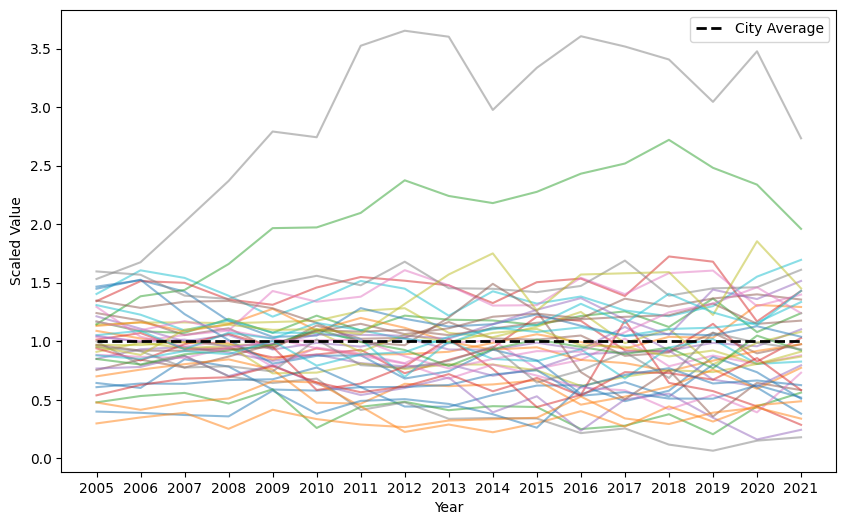

In [ ]:
# The rates normalized by the average per year
R5_rates = df[years].div(average_per_year, axis=1)
plt.figure(figsize=(10, 6))
for index, row in R5_rates.iterrows():
    plt.plot(years, row, label='_nolegend_', alpha=0.5)
plt.plot(years, [1]*len(years), 'k--', linewidth=2, label='City Average')  # Average line as a dashed line
plt.xlabel('Year')
plt.ylabel('Scaled Value')
plt.title('')
plt.legend()
plt.show()


In [ ]:
# Create df_rates with GeoID  predict future rates
df_rates = df.copy()
df_rates['rates'] = df[['2019', '2020', '2021']].mean(axis=1)
df_rates['average_tests'] = tests.loc[:, '2005':'2021'].mean(axis=1)
# Keep only GeoID and rates in df_rates
df_rates = df_rates[['GeoID', 'rates','average_tests']]
df_rates['cases_ratio'] =(df_rates['rates'] * df_rates['average_tests']/ 1000)
# Normalizing by dividing by the sum of the column cases_ratio
df_rates['cases_ratio'] =100* df_rates['cases_ratio'] / df_rates['cases_ratio'].sum()
# Displaying the first few rows of df_rates
print(df_rates.head(5))
# Normalization
averages = df.iloc[:, 1:].mean()
# Divide each value in the column by the corresponding average
normalized_df = df.iloc[:, 1:].div(averages)
# Concatenate the 'GeoID' column back
R5_df = pd.concat([df['GeoID'], normalized_df], axis=1)
#print(R5_df.head(5))

   GeoID      rates  average_tests  cases_ratio
0    101   6.700000    2923.529412     0.591790
1    102  11.566667    6310.588235     2.205278
2    103  11.666667   12342.941176     4.350615
3    104   9.500000   11385.882353     3.267951
4    105   9.666667   10763.529412     3.143523


In [ ]:
# Create a new DataFrame for 2021 data
# Create a new DataFrame for 2021 data with only GeoID
R5_2021_df = df[['GeoID']].copy()
# Calculate the total tests and cases for 2021
total_tests_2021 = tests['2021'].sum()
total_cases_2021 = df['2021'].sum()
# Calculate the testing ratio and cases ratio for 2021
R5_2021_df['testing_ratio_2021'] = tests['2021'] / total_tests_2021 * 100
R5_2021_df['cases_ratio_2021'] = df['2021'] / total_cases_2021 * 100
# Display the first few rows of the new DataFrame
print(R5_2021_df.head(5))


   GeoID  testing_ratio_2021  cases_ratio_2021
0    101            0.975257          1.210898
1    102            2.095311          3.077699
2    103            3.837145          2.951564
3    104            4.139517          2.447023
4    105            3.355905          2.623613


In [ ]:
import pandas as pd
import numpy as np
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import cdist
# Predefined centroids for the k medoids clustering algorithm with their GeoIDs
predefined_clusters = {
    211: 'high',
    304: 'low',
    107: 'declining',
    102: 'rising',
    105: 'average'
}

# Perform initial k-medoids clustering
data_for_clustering = R5_df.drop('GeoID', axis=1)
kmedoids = KMedoids(n_clusters=5, method='pam', random_state=0)
kmedoids.fit(data_for_clustering)

# Replace the initial medoids with the predefined ones
for i, geo_id in enumerate(predefined_clusters):
    medoid_index = R5_df.index[R5_df['GeoID'] == geo_id].tolist()
    if medoid_index:
        kmedoids.medoid_indices_[i] = medoid_index[0]

# Calculate distances between each time series and the predefined centroids
centroids = data_for_clustering.iloc[kmedoids.medoid_indices_]
distances = cdist(data_for_clustering, centroids, metric='euclidean')

# Assign each time series to the nearest predefined centroid
nearest_centroids = np.argmin(distances, axis=1)

# Create a new DataFrame and add the 'Cluster' column
k_df = R5_df.copy()
k_df['Cluster'] = [list(predefined_clusters.values())[index] for index in nearest_centroids]


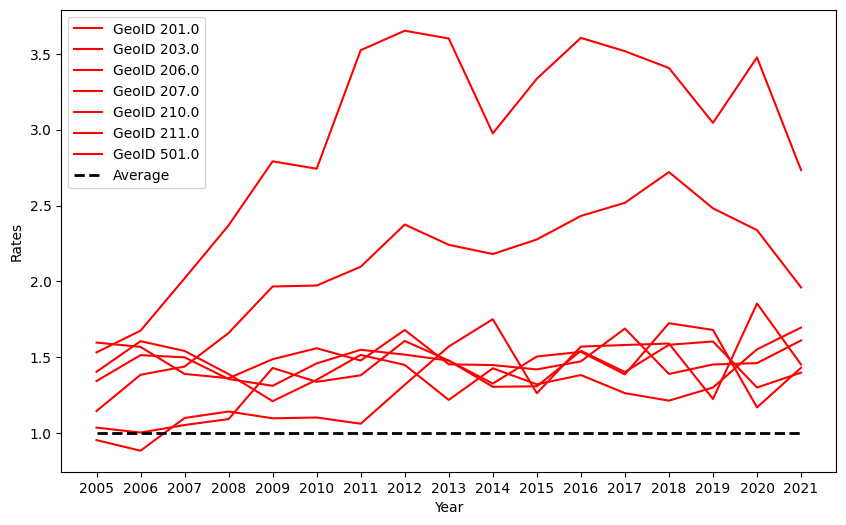

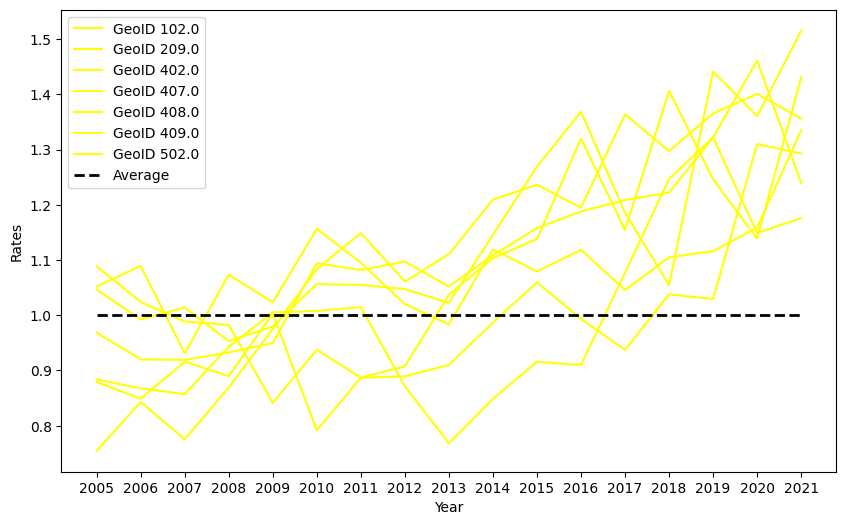

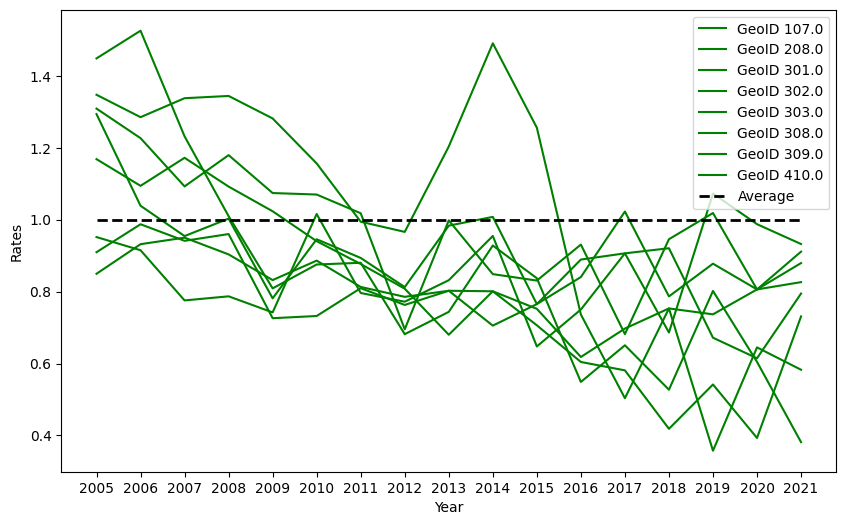

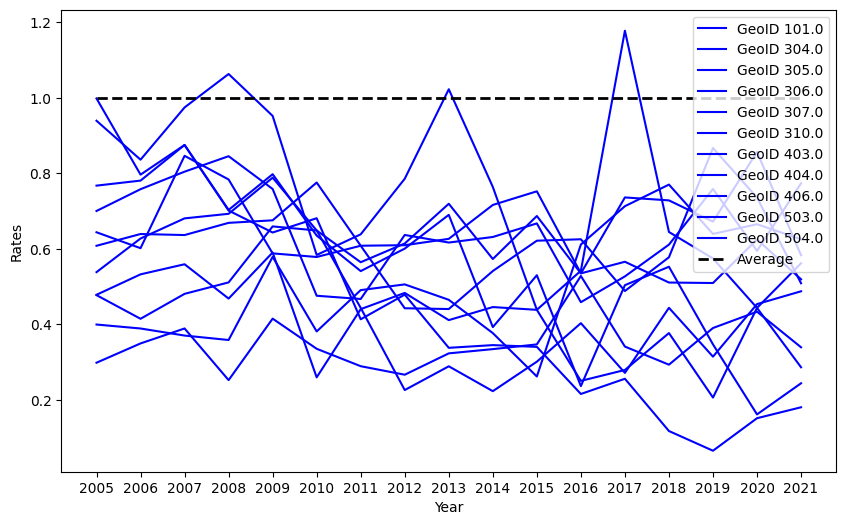

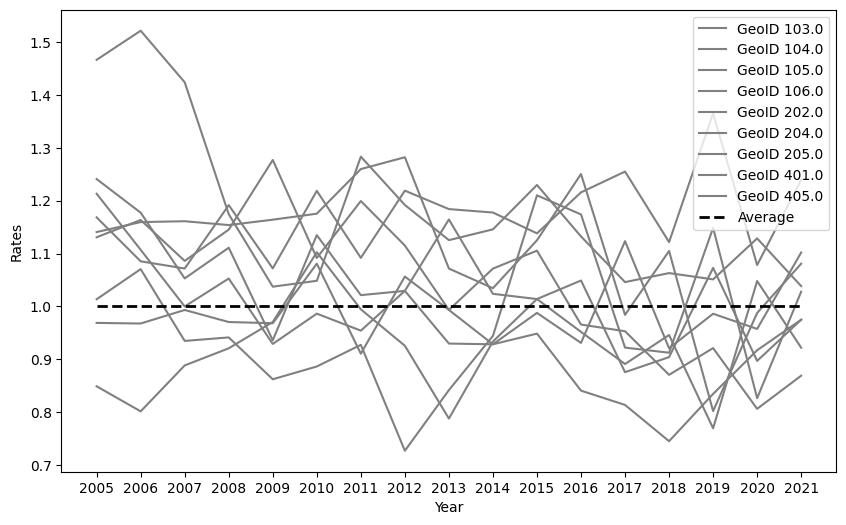

In [ ]:
color_mapping = {'high': 'red','rising': 'yellow','declining': 'green','low': 'blue','average': 'grey'}
# Years for the x-axis (assuming the first column is 'GeoID')
years = R5_df.columns[1:]
# Plotting each cluster category in a separate plot
for cluster, color in color_mapping.items():
    # Filter GeoIDs based on the current cluster category
    selected_geo_ids = k_df[k_df['Cluster'] == cluster]['GeoID'].unique()
    filtered_df = R5_df[R5_df['GeoID'].isin(selected_geo_ids)]
    # Create a plot for the current cluster category
    plt.figure(figsize=(10, 6))
    for index, row in filtered_df.iterrows():
        plt.plot(years, row[1:], label=f'GeoID {row["GeoID"]}', color=color)
    plt.plot(years, [1]*len(years), 'k--', linewidth=2, label='Average')
    plt.xlabel('Year')
    plt.ylabel('Rates')
    plt.title(f'')
    plt.legend()
    plt.show()


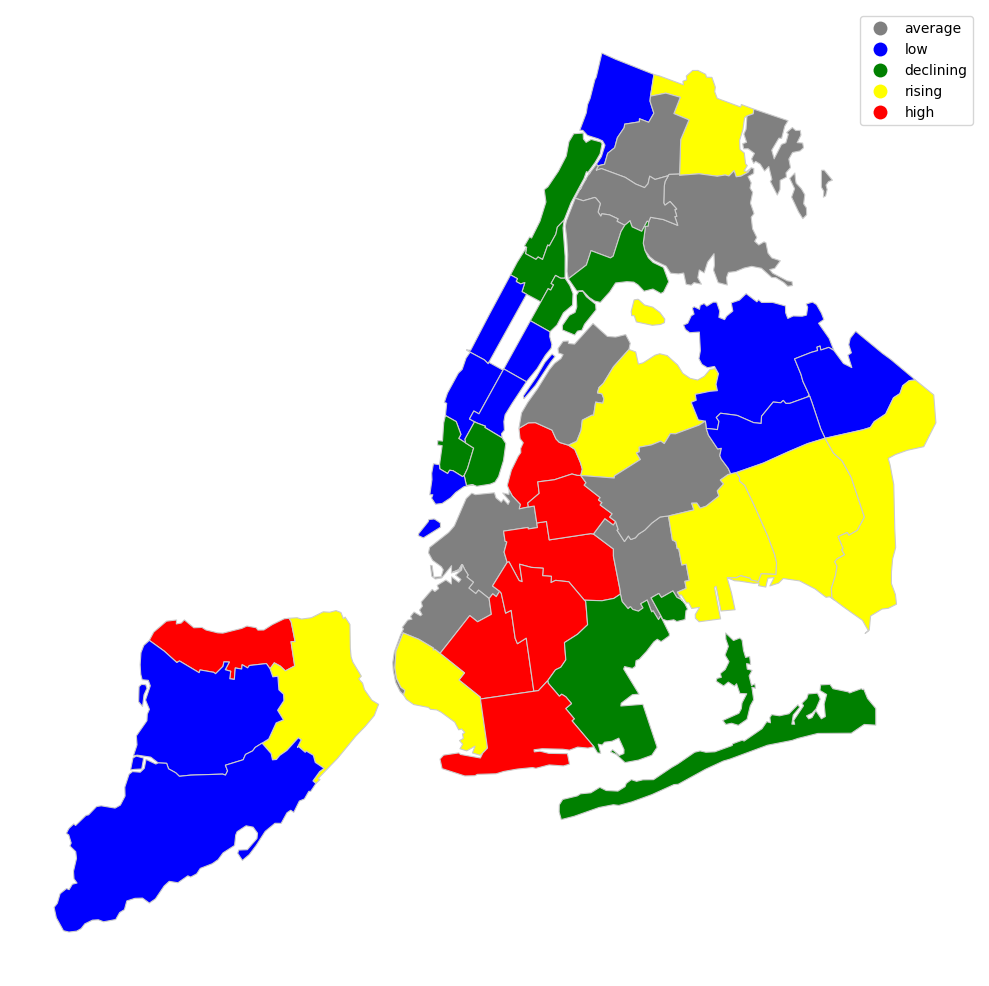

In [ ]:
# Define the color map and label order
color_dict = {
    'high': 'red',
    'rising': 'yellow',
    'declining': 'green',
    'low': 'blue',
    'average': 'grey'
}
label_order = ['average', 'low', 'declining', 'rising', 'high']
colors = [color_dict[label] for label in label_order]
cmap = ListedColormap(colors)

# Merge the k_df DataFrame with the GeoDataFrame based on the 'GEOCODE' and 'GeoID' columns
merged_data = geo_json_data.merge(k_df, left_on="GEOCODE", right_on="GeoID")

# Create the choropleth map with the cluster data
categories = ['average', 'low', 'declining', 'rising', 'high']
merged_data['Cluster'] = pd.Categorical(merged_data['Cluster'], categories=categories, ordered=True)
fig, ax = plt.subplots(1, figsize=(10, 10))
merged_data.plot(column="Cluster", cmap=cmap, linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)
ax.set_title("")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("nyc_choropleth_difference.png")
plt.show()
#print(merged_data)

### **Now We will analyze the testing policy **

   GeoID      2005      2006      2007      2008      2009      2010  \
0    101  0.382812  0.391262  0.426126  0.413157  0.420382  0.432990   
1    102  0.929688  0.930935  0.945466  0.942515  0.955414  0.903093   
2    103  1.777344  1.794411  1.771084  1.768829  1.770701  1.719588   
3    104  1.585938  1.565050  1.558022  1.562250  1.554140  1.521649   
4    105  1.544922  1.605525  1.611287  1.562250  1.541401  1.472165   

       2011      2012      2013      2014      2015      2016      2017  \
0  0.418523  0.436297  0.431373  0.429530  0.379845  0.353179  0.358974   
1  0.873974  0.846929  0.849673  0.832215  0.800388  0.819374  0.818462   
2  1.711020  1.655362  1.673203  1.704698  1.682171  1.681130  1.694359   
3  1.526377  1.539872  1.529412  1.503356  1.560078  1.568113  1.593846   
4  1.464830  1.462878  1.464052  1.463087  1.465116  1.455096  1.450256   

       2018      2019      2020      2021  
0  0.384101  0.382487  0.399776  0.409608  
1  0.842068  0.809107  0.806

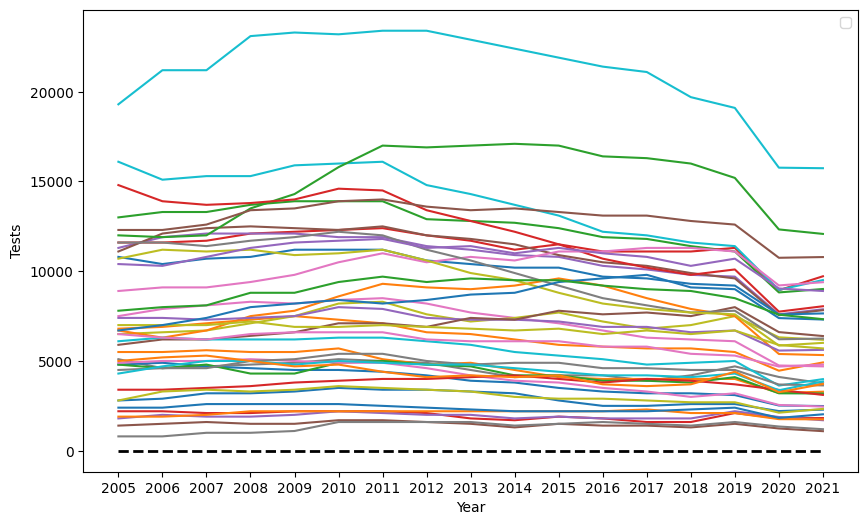

In [ ]:

# Exclude the last column for analysis
columns_for_analysis = tests.columns[:-1]
# Calculate the averages for each column, excluding 'GeoID' and the last column
averages = tests[columns_for_analysis[1:]].mean()
# Normalize the data, excluding the last column
normalized_tests = tests[columns_for_analysis[1:]].div(averages)
# Concatenate the 'GeoID' column back, still excluding the last column
normalized_df = pd.concat([tests['GeoID'], normalized_tests], axis=1)
print(normalized_df.head(5))

# Plotting
years = normalized_df.columns[1:]
plt.figure(figsize=(10, 6))
for index, row in tests[columns_for_analysis].iterrows():
    plt.plot(years, row[1:], label='_nolegend_')
plt.plot(years, [1]*len(years), 'k--', linewidth=2, label='')
plt.xlabel('Year')
plt.ylabel('Tests')
plt.title('')
plt.legend()
plt.show()


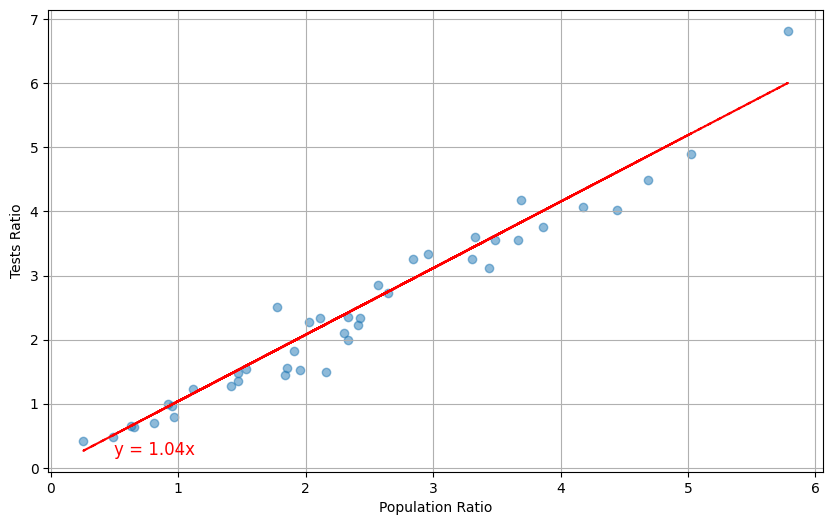

In [ ]:
avg_tests = round(tests.iloc[:, 1:].mean(axis=1))
final_df = pd.DataFrame({
    'GeoID': tests['GeoID'],
    'avg_tests': avg_tests,
    'child_pop': tests['u5Pop']
})

final_df['tests_ratio'] = (final_df['avg_tests'] / final_df['avg_tests'].sum()) * 100
final_df['pop_ratio'] = (final_df['child_pop'] / final_df['child_pop'].sum()) * 100
final_df['test/pop'] = final_df['tests_ratio'] / final_df['pop_ratio']

# Linear Regression to fit the best line through the origin
slope = np.polyfit(final_df['pop_ratio'], final_df['tests_ratio'], 1, full=False)[0]
line = slope * final_df['pop_ratio']

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(final_df['pop_ratio'], final_df['tests_ratio'], alpha=0.5)
plt.plot(final_df['pop_ratio'], line, 'r--')  # Best fit line

# Add the equation of the line
plt.text(0.5, 0.2, f'y = {slope:.2f}x', fontsize=12, color='red')

plt.xlabel('Population Ratio')
plt.ylabel('Tests Ratio')
plt.title('')
plt.grid(True)
plt.show()


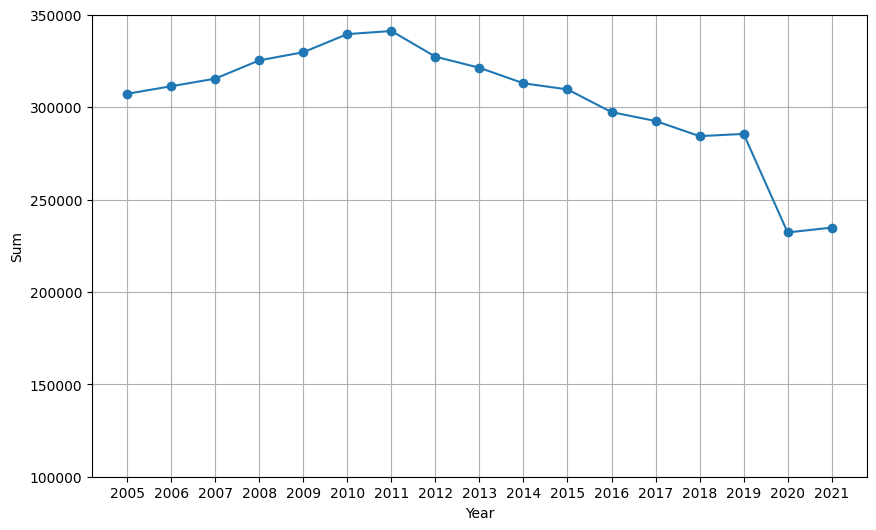

In [ ]:
# The impact of COVID
yearly_data = tests.iloc[:, 1:-1]
# Calculate the sum of each column
sums_over_years = yearly_data.sum()
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sums_over_years.index, sums_over_years.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Sum')
plt.ylim(100000,350000)
plt.title('')
plt.grid(True)
plt.show()


In [ ]:
# Further Evaluation of the testing policy
final_df = pd.merge(final_df[['GeoID', 'child_pop', 'avg_tests','pop_ratio' ,'tests_ratio','test/pop']], merged_data[['GeoID', 'Cluster']],
                    on='GeoID', how='inner')
final_df = final_df.rename(columns={ 'Cluster': 'label'})
label_encoding = {'high': 5, 'rising': 4, 'average': 3, 'declining': 1, 'low': 1}
final_df['encoded_label'] = final_df['label'].map(label_encoding)
final_df['encoded_label'] = final_df['encoded_label'].astype(int)
final_df = pd.merge(final_df,df_rates[['GeoID', 'rates','cases_ratio']],on='GeoID',how='left' )
# Calculate 'v1_cases' as the product of 'rates' and 'v1_tests' divided by 1000
final_df['avg_cases'] = round((final_df['rates'] * final_df['avg_tests']) / 1000)

In [ ]:
from IPython.display import display
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Display the DataFrame with horizontal scroll
sorted_df = final_df.sort_values(by='GeoID', ascending=True)
print(sorted_df.columns)
display(sorted_df)


Index(['GeoID', 'child_pop', 'avg_tests', 'pop_ratio', 'tests_ratio', 'test/pop', 'label',
       'encoded_label', 'rates', 'cases_ratio', 'avg_cases'],
      dtype='object')


,GeoID,child_pop,avg_tests,pop_ratio,tests_ratio,test/pop,label,encoded_label,rates,cases_ratio,avg_cases
0,101,5158,3048.0,0.953635,0.961156,1.007887,low,1,6.700000,0.591790,20.0
1,102,12438,6651.0,2.299594,2.097327,0.912042,rising,4,11.566667,2.205278,77.0
2,103,22581,12912.0,4.174879,4.071670,0.975279,average,3,11.666667,4.350615,151.0
3,104,20886,11914.0,3.861499,3.756961,0.972928,average,3,9.500000,3.267951,113.0
4,105,19812,11266.0,3.662933,3.552621,0.969884,average,3,9.666667,3.143523,109.0
5,106,18019,11400.0,3.331435,3.594876,1.079077,average,3,9.333333,3.104792,106.0
6,107,11418,7415.0,2.111012,2.338246,1.107642,declining,1,8.133333,1.764179,60.0
7,201,10562,4852.0,1.952751,1.530030,0.783525,high,5,29.466667,4.020304,143.0
8,202,12614,7467.0,2.332134,2.354644,1.009652,average,3,9.133333,1.977028,68.0
9,203,25326,14261.0,4.682387,4.497064,0.960421,high,5,14.466667,5.948560,206.0


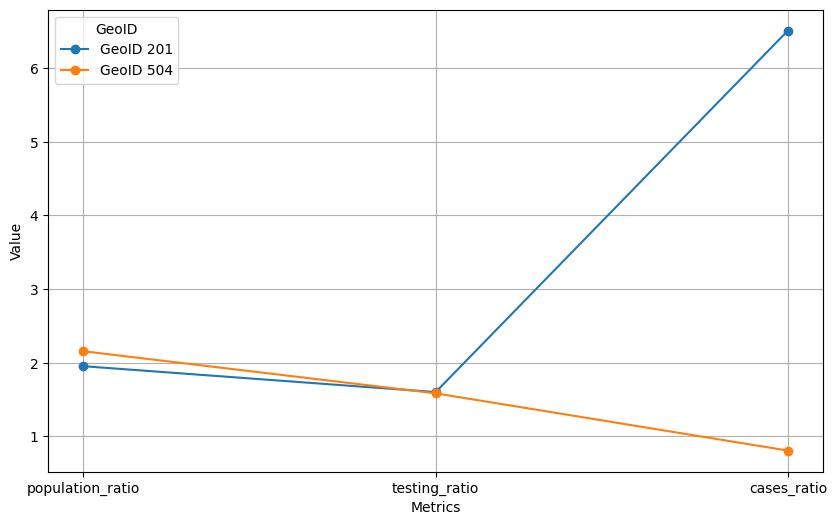

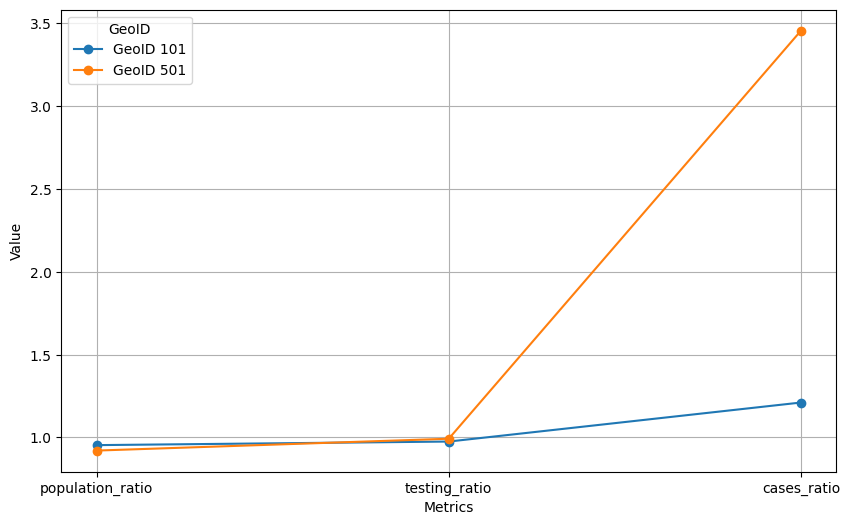

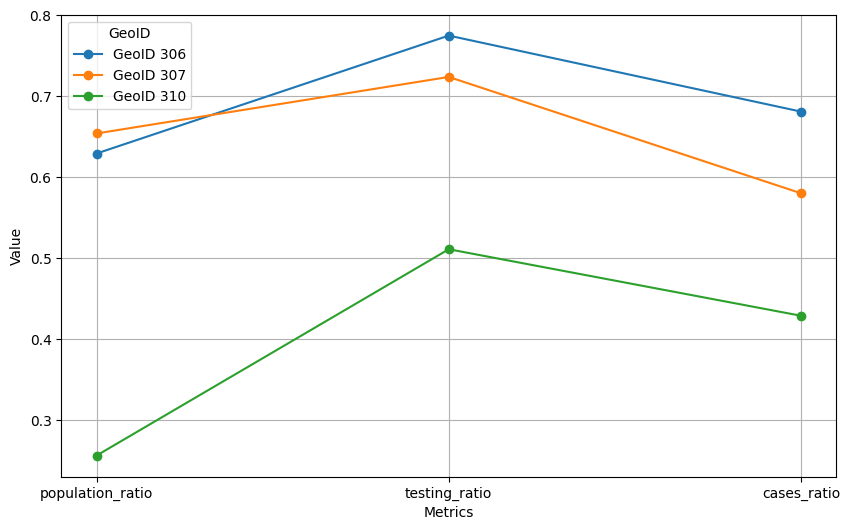

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_geo_ratios(geo_ids, final_df, R5_2021_df, title):
    # Filter data based on GeoID
    final_df_filtered = final_df[final_df['GeoID'].isin(geo_ids)]
    R5_2021_df_filtered = R5_2021_df[R5_2021_df['GeoID'].isin(geo_ids)]

    # Creating a temporary DataFrame for the specified GeoIDs
    data = {
        'GeoID': geo_ids,
        'population_ratio': [final_df_filtered[final_df_filtered['GeoID'] == geo_id]['pop_ratio'].values[0] for geo_id in geo_ids if geo_id in final_df_filtered['GeoID'].values],
        'testing_ratio': [R5_2021_df_filtered[R5_2021_df_filtered['GeoID'] == geo_id]['testing_ratio_2021'].values[0] for geo_id in geo_ids if geo_id in R5_2021_df_filtered['GeoID'].values],
        'cases_ratio': [R5_2021_df_filtered[R5_2021_df_filtered['GeoID'] == geo_id]['cases_ratio_2021'].values[0] for geo_id in geo_ids if geo_id in R5_2021_df_filtered['GeoID'].values]
    }
    temp_df = pd.DataFrame(data)
    temp_df.set_index('GeoID', inplace=True)

    # Plotting the data as a line chart
    plt.figure(figsize=(10, 6))
    for geo_id in temp_df.index:
        plt.plot(temp_df.columns, temp_df.loc[geo_id], label=f'GeoID {geo_id}', marker='o')

    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title(title)
    plt.xticks(rotation=0)
    plt.legend(title='GeoID')
    plt.grid(True)
    plt.show()

# Assuming final_df and R5_2021_df are already defined in your code

# Call the function with different sets of GeoIDs and titles
plot_geo_ratios([201, 504], final_df, R5_2021_df, '')
plot_geo_ratios([101, 501], final_df, R5_2021_df, '')
plot_geo_ratios([306, 307, 310], final_df, R5_2021_df, '')

In [ ]:
print(df_rates.head(5))

   GeoID      rates  average_tests  cases_ratio
0    101   6.700000    2923.529412     0.591790
1    102  11.566667    6310.588235     2.205278
2    103  11.666667   12342.941176     4.350615
3    104   9.500000   11385.882353     3.267951
4    105   9.666667   10763.529412     3.143523


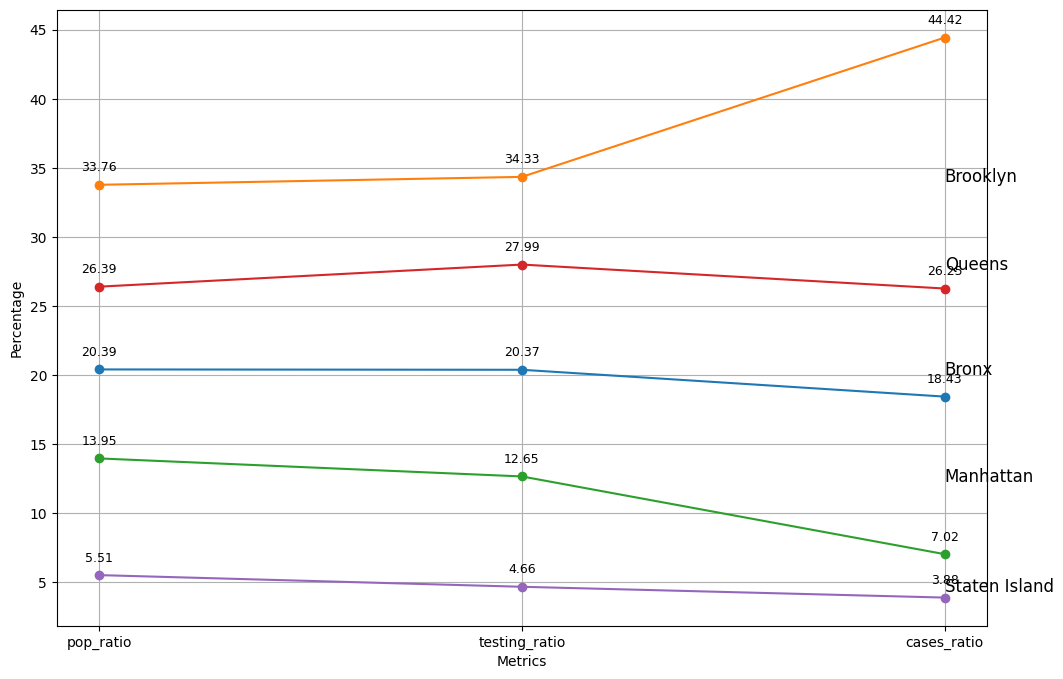

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def get_borough(geo_id):
    first_digit = int(str(geo_id)[0])
    return {
        1: 'Bronx',
        2: 'Brooklyn',
        3: 'Manhattan',
        4: 'Queens',
        5: 'Staten Island'
    }.get(first_digit, 'Unknown')

# Add a new column for borough in df_rates
df_rates['Borough'] = df_rates['GeoID'].apply(get_borough)

# Merge df_rates with final_df on GeoID to get 'pop_ratio'
merged_df = pd.merge(df_rates, final_df[['GeoID', 'pop_ratio']], on='GeoID')
merged_df['testing_ratio'] = 100*merged_df['average_tests'] / merged_df['average_tests'].sum()
# Group by 'Borough' and calculate percentages
borough_sums = merged_df.groupby('Borough').sum()
total_sums = borough_sums.sum()
borough_percentages = (borough_sums * 100 / total_sums).reset_index()

# Calculate testing_ratio as the number of tests for each GeoID divided by the total tests

# Define the order of metrics on the x-axis
metric_order = ['pop_ratio', 'testing_ratio', 'cases_ratio']

# Plotting the percentages for each borough with the specified metric order
plt.figure(figsize=(12, 8))
for idx, row in borough_percentages.iterrows():
    plt.plot(metric_order, row[metric_order], marker='o')
    for metric, value in zip(metric_order, row[metric_order]):
        plt.annotate(f'{value:.2f}', (metric, value), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

# Adding elegant line labels directly
for i, label in enumerate(borough_percentages['Borough']):
    plt.text(metric_order[-1], borough_percentages.iloc[i][-1], label, fontsize=12, va='center')

plt.xlabel('Metrics')
plt.ylabel('Percentage')
plt.title('')
plt.grid(True)
plt.show()


In [ ]:
print(borough_percentages)

         Borough      GeoID      rates  average_tests  cases_ratio  pop_ratio  testing_ratio
0          Bronx   6.009576  16.630580      20.370059    18.428127  20.394987      20.370059
1       Brooklyn  18.705630  38.657562      34.332697    44.416057  33.759739      34.332697
2      Manhattan  25.218755  12.633245      12.648797     7.023774  13.952869      12.648797
3         Queens  33.473667  22.984677      27.986043    26.251934  26.385987      27.986043
4  Staten Island  16.592372   9.093937       4.662405     3.880108   5.506417       4.662405


# **Step 4: Optimize the tetsing distribution **

In [ ]:
from google.colab import files
future_tests = 262700
opt_df = final_df.copy()
opt_df = opt_df.rename(columns={'tests_ratio': 'v1_tests_ratio'})
# Add the new column 'v1_tests'
opt_df['v1_tests'] =round(opt_df['v1_tests_ratio'] * future_tests / 100)
# Merge the 'rates' column from df_rates into opt_df
#opt_df = pd.merge(opt_df,df_rates[['GeoID', 'rates','cases_ratio']],on='GeoID',how='left' )
# Calculate 'v1_cases' as the product of 'rates' and 'v1_tests' divided by 1000
opt_df['v1_cases'] = round((opt_df['rates'] * opt_df['v1_tests']) / 1000)
# Display the first few rows of the updated DataFrame
sorted_df = opt_df.sort_values(by='rates', ascending=True)
print(sorted_df.columns)

Index(['GeoID', 'child_pop', 'avg_tests', 'pop_ratio', 'v1_tests_ratio', 'test/pop', 'label',
       'encoded_label', 'rates', 'cases_ratio', 'avg_cases', 'v1_tests', 'v1_cases'],
      dtype='object')


In [ ]:
# Random Search
def new_test_ratio(row, p1, p2):
    x = row['v1_tests_ratio']
    y = row['cases_ratio']
    return x * p1 + y * p2
# Random search
num_iterations = 1000  # Number of iterations for the random search
results_df = pd.DataFrame()

for _ in range(num_iterations):
    p1 = np.random.uniform(-5, 5)  # Randomly sample p1
    p2 = np.random.uniform(-5, 5)  # Randomly sample p2

    # Apply the function
    opt_df['v2_tests_ratio'] = opt_df.apply(new_test_ratio, axis=1, args=(p1, p2))
    opt_df['v2_tests_ratio'] = opt_df['v2_tests_ratio'] * 100 / opt_df['v2_tests_ratio'].sum()
    opt_df['v2_tests'] = opt_df['v2_tests_ratio'] * future_tests / 100
    opt_df['v2_cases'] = opt_df['rates'] * opt_df['v2_tests'] / 1000
    opt_df['diff'] = opt_df['v2_cases'] - opt_df['v1_cases']

    # Check constraints
    if (opt_df['diff'].sum() < 400 or opt_df['diff'].min() < -20) or \
       any((opt_df['cases_ratio'] > 1.5) & ((opt_df['v2_cases'] / opt_df['v1_cases']) < 0.75)) or \
       any(((opt_df['label'] == 'high') | (opt_df['label'] == 'rising')) & (opt_df['diff'] < 0)) or \
       any((opt_df['v2_tests'] > opt_df['child_pop'])):
        continue
    else:
        # Store results for valid parameter combinations
        current_row_df = pd.DataFrame([{
            'p1': p1, 'p2': p2,
            'diff_sum': opt_df['diff'].sum(),
            'diff_min': opt_df['diff'].min()
        }])
        results_df = pd.concat([results_df, current_row_df], ignore_index=True)

# Print sorted results
sorted_results_df = results_df.sort_values(by='diff_sum', ascending=False)
print(sorted_results_df.head(5))
best_params = sorted_results_df.iloc[0]
print("Best parameters found: ", best_params)

# Extract best parameters
best_p1 = best_params['p1']
best_p2 = best_params['p2']

# Recalculate the values using the best parameters
opt_df['v2_tests_ratio'] = opt_df.apply(new_test_ratio, axis=1, args=(best_p1, best_p2))
opt_df['v2_tests_ratio'] = opt_df['v2_tests_ratio'] * 100 / opt_df['v2_tests_ratio'].sum()
opt_df['v2_tests'] = round(opt_df['v2_tests_ratio'] * future_tests / 100)
opt_df['v2_cases'] = round(opt_df['rates'] * opt_df['v2_tests'] / 1000)
opt_df['diff'] = round(opt_df['v2_cases'] - opt_df['v1_cases'])

print(opt_df[['label', 'v1_tests', 'v2_tests', 'rates', 'v1_cases', 'v2_cases', 'diff']])


          p1        p2    diff_sum   diff_min
9   0.363764  2.052410  413.728851 -16.762527
5  -0.445353 -2.504462  413.523353 -16.754308
10 -0.338247 -1.900367  413.465027 -16.751975
6   0.210456  1.172319  412.929540 -16.730559
3   0.774725  4.312482  412.885554 -16.728800
Best parameters found:  p1            0.363764
p2            2.052410
diff_sum    413.728851
diff_min    -16.762527
Name: 9, dtype: float64
        label  v1_tests  v2_tests      rates  v1_cases  v2_cases   diff
0         low    2525.0    1701.0   6.700000      17.0      11.0   -6.0
1      rising    5510.0    5751.0  11.566667      64.0      67.0    3.0
2     average   10696.0   11319.0  11.666667     125.0     132.0    7.0
3     average    9870.0    8778.0   9.500000      94.0      83.0  -11.0
4     average    9333.0    8420.0   9.666667      90.0      81.0   -9.0
5     average    9444.0    8350.0   9.333333      88.0      78.0  -10.0
6   declining    6143.0    4862.0   8.133333      50.0      40.0  -10.0
7       

In [ ]:
v1_cases_sum = opt_df['v2_cases'].sum()
print("Sum of v2_cases:", v1_cases_sum)

Sum of v2_cases: 3270.0


In [ ]:
# Using grid search for the best distribution
def new_test_ratio(row, p1, p2):
    x = row['v1_tests_ratio']
    y = row['cases_ratio']
    return x * p1 + y * p2
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame()
# Define ranges
p1_values = np.arange(-5, 5.1, 0.2)
p2_values = np.arange(-5, 5.1, 0.2)
# Grid search
for p1 in p1_values:
    for p2 in p2_values:
        # Apply the function
        opt_df['v2_tests_ratio'] = opt_df.apply(new_test_ratio, axis=1, args=(p1, p2))
        opt_df['v2_tests_ratio'] =opt_df['v2_tests_ratio'] * 100 / opt_df['v2_tests_ratio'].sum()
        opt_df['v2_tests'] = opt_df['v2_tests_ratio'] * future_tests / 100
        opt_df['v2_cases'] = opt_df['rates'] * opt_df['v2_tests'] / 1000
        opt_df['diff'] = opt_df['v2_cases'] - opt_df['v1_cases']
        #print(opt_df[['label','v1_tests','v2_tests','v1_cases','v2_cases','diff']])
        if (opt_df['diff'].sum() < 300 or opt_df['diff'].min() < -20) or any((opt_df['cases_ratio'] > 1.5) & ((opt_df['v2_cases'] / opt_df['v1_cases']) < 0.75))\
                or any(((opt_df['label'] == 'high') | (opt_df['label'] == 'rising')) & (opt_df['diff'] < 0))\
                or any((opt_df['v2_tests']>opt_df['child_pop'])):
                 #print(opt_df['diff'].sum())
                 continue
        else:
            #print("Good combination found")
            #print(opt_df['diff'].sum())
            # Create a DataFrame for the current row and concatenate it with the results_df
            current_row_df = pd.DataFrame([{
                'p1': p1, 'p2': p2,
                'diff_sum': opt_df['diff'].sum(),
                'diff_min': opt_df['diff'].min()
            }])
            results_df = pd.concat([results_df, current_row_df], ignore_index=True)

# Print sorted results
sorted_results_df = results_df.sort_values(by='diff_sum', ascending=False)
print(sorted_results_df.head(5))
best_params = sorted_results_df.iloc[0]
print("parameters used : ",best_params)
# Extract best parameters
best_p1 = best_params['p1']
best_p2 = best_params['p2']
# Recalculate the values using the best parameters
        # Apply the function
opt_df['v2_tests_ratio'] = opt_df.apply(new_test_ratio, axis=1, args=(best_p1, best_p2))
opt_df['v2_tests_ratio'] =opt_df['v2_tests_ratio'] * 100 / opt_df['v2_tests_ratio'].sum()
opt_df['v2_tests'] = round(opt_df['v2_tests_ratio'] * future_tests / 100)
opt_df['v2_cases'] = round(opt_df['rates'] * opt_df['v2_tests'] / 1000)
opt_df['diff'] = round(opt_df['v2_cases'] - opt_df['v1_cases'])
print(opt_df[['label','v1_tests','v2_tests','rates','v1_cases','v2_cases','diff']])

      p1   p2    diff_sum   diff_min
103 -0.8 -4.6  414.897916 -16.809283
186  0.8  4.6  414.897916 -16.809283
169  0.6  3.4  413.997943 -16.773289
120 -0.6 -3.4  413.997943 -16.773289
133 -0.4 -2.2  412.128770 -16.698533
parameters used :  p1           -0.800000
p2           -4.600000
diff_sum    414.897916
diff_min    -16.809283
Name: 103, dtype: float64
        label  v1_tests  v2_tests      rates  v1_cases  v2_cases   diff
0         low    2525.0    1698.0   6.700000      17.0      11.0   -6.0
1      rising    5510.0    5751.0  11.566667      64.0      67.0    3.0
2     average   10696.0   11321.0  11.666667     125.0     132.0    7.0
3     average    9870.0    8775.0   9.500000      94.0      83.0  -11.0
4     average    9333.0    8417.0   9.666667      90.0      81.0   -9.0
5     average    9444.0    8347.0   9.333333      88.0      78.0  -10.0
6   declining    6143.0    4858.0   8.133333      50.0      40.0  -10.0
7        high    4019.0    9592.0  29.466667     118.0     283.0 

In [ ]:
opt_df['v2_cases_ratio'] = 100 * opt_df['v2_cases'] / opt_df['v2_cases'].sum()
print(opt_df[['GeoID','pop_ratio','v2_tests_ratio','v2_cases_ratio']])

    GeoID  pop_ratio  v2_tests_ratio  v2_cases_ratio
0     101   0.953635        0.646511        0.336391
1     102   2.299594        2.189285        2.048930
2     103   4.174879        4.309290        4.036697
3     104   3.861499        3.340397        2.538226
4     105   3.662933        3.204130        2.477064
5     106   3.331435        3.177397        2.385321
6     107   2.111012        1.849226        1.223242
7     201   1.952751        3.651374        8.654434
8     202   2.332134        2.032971        1.498471
9     203   4.682387        5.733523        6.666667
10    204   2.839642        3.128172        2.568807
11    205   1.772673        2.124850        1.467890
12    206   5.022759        8.968129       15.504587
13    207   4.442776        4.812968        5.229358
14    208   2.424391        1.549515        0.825688
15    209   2.027259        2.690636        2.844037
16    210   2.960372        4.089087        4.464832
17    211   3.302593        4.132957        4.

In [ ]:
# Calculate the new column 'v2test/pop'
opt_df['v2test/pop'] = opt_df['v2_tests_ratio'] / opt_df['pop_ratio']
opt_df['testsdiff'] = opt_df['v2_tests'] - opt_df['v1_tests']
# Calculate the sum of the 'title' column
# Create the 'v1_cases_ratio' column by dividing 'v1_cases' by the sum of 'title'
opt_df['v1_cases_ratio'] =100* opt_df['v1_cases'] / opt_df['v1_cases'].sum()

In [ ]:
from IPython.display import display
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Display the DataFrame with horizontal scroll
sorted_df = opt_df.sort_values(by='GeoID', ascending=True)
print(sorted_df.columns)
display(sorted_df)


Index(['GeoID', 'child_pop', 'avg_tests', 'pop_ratio', 'v1_tests_ratio', 'test/pop', 'label',
       'encoded_label', 'rates', 'cases_ratio', 'avg_cases', 'v1_tests', 'v1_cases',
       'v2_tests_ratio', 'v2_tests', 'v2_cases', 'diff', 'v2_cases_ratio', 'v2test/pop',
       'testsdiff', 'v1_cases_ratio'],
      dtype='object')


,GeoID,child_pop,avg_tests,pop_ratio,v1_tests_ratio,test/pop,label,encoded_label,rates,cases_ratio,avg_cases,v1_tests,v1_cases,v2_tests_ratio,v2_tests,v2_cases,diff,v2_cases_ratio,v2test/pop,testsdiff,v1_cases_ratio
0,101,5158,3048.0,0.953635,0.961156,1.007887,low,1,6.700000,0.591790,20.0,2525.0,17.0,0.646511,1698.0,11.0,-6.0,0.336391,0.677944,-827.0,0.594406
1,102,12438,6651.0,2.299594,2.097327,0.912042,rising,4,11.566667,2.205278,77.0,5510.0,64.0,2.189285,5751.0,67.0,3.0,2.048930,0.952031,241.0,2.237762
2,103,22581,12912.0,4.174879,4.071670,0.975279,average,3,11.666667,4.350615,151.0,10696.0,125.0,4.309290,11321.0,132.0,7.0,4.036697,1.032195,625.0,4.370629
3,104,20886,11914.0,3.861499,3.756961,0.972928,average,3,9.500000,3.267951,113.0,9870.0,94.0,3.340397,8775.0,83.0,-11.0,2.538226,0.865052,-1095.0,3.286713
4,105,19812,11266.0,3.662933,3.552621,0.969884,average,3,9.666667,3.143523,109.0,9333.0,90.0,3.204130,8417.0,81.0,-9.0,2.477064,0.874744,-916.0,3.146853
5,106,18019,11400.0,3.331435,3.594876,1.079077,average,3,9.333333,3.104792,106.0,9444.0,88.0,3.177397,8347.0,78.0,-10.0,2.385321,0.953762,-1097.0,3.076923
6,107,11418,7415.0,2.111012,2.338246,1.107642,declining,1,8.133333,1.764179,60.0,6143.0,50.0,1.849226,4858.0,40.0,-10.0,1.223242,0.875990,-1285.0,1.748252
7,201,10562,4852.0,1.952751,1.530030,0.783525,high,5,29.466667,4.020304,143.0,4019.0,118.0,3.651374,9592.0,283.0,165.0,8.654434,1.869862,5573.0,4.125874
8,202,12614,7467.0,2.332134,2.354644,1.009652,average,3,9.133333,1.977028,68.0,6186.0,56.0,2.032971,5341.0,49.0,-7.0,1.498471,0.871721,-845.0,1.958042
9,203,25326,14261.0,4.682387,4.497064,0.960421,high,5,14.466667,5.948560,206.0,11814.0,171.0,5.733523,15062.0,218.0,47.0,6.666667,1.224487,3248.0,5.979021


In [ ]:
v1_cases_sum = opt_df['v1_cases_ratio'].sum()
print("Sum of v1_cases:", v1_cases_sum)
v2_cases_sum =opt_df['v2_cases'].sum()
print("Sum of v2_cases:", v2_cases_sum)

Sum of v1_cases: 100.0
Sum of v2_cases: 3270.0


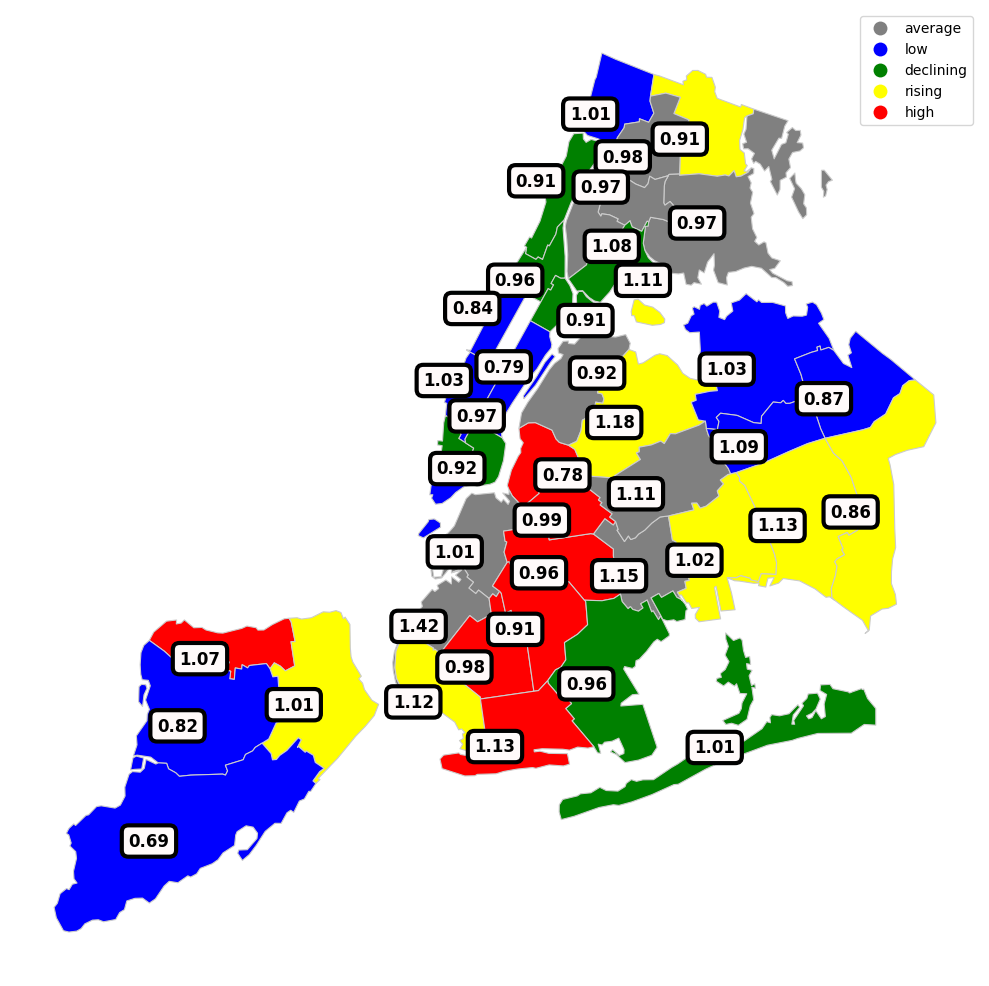

In [ ]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Create the choropleth map
fig, ax = plt.subplots(1, figsize=(10, 10))
merged_data.plot(column="Cluster", cmap=cmap, linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

# Annotate each area with the tests_ratio value, rounded to two decimal places
# We use a dictionary to map GeoID to tests_ratio for efficient lookup
tests_ratio_dict = final_df.set_index('GeoID')['test/pop'].to_dict()
texts = []

for idx, row in merged_data.iterrows():
    geo_id = row['GeoID']
    tests_ratio = tests_ratio_dict.get(geo_id, '')
    if tests_ratio:
        # Round the value and convert to string for display
        tests_ratio_text = f"{tests_ratio:.2f}"

        # Create a background rectangle
        bbox_props = dict(boxstyle="round, pad=0.4", ec="black", lw=3, fc="snow")  # Adjust padding and colors as needed

        if geo_id == 308:
            # For GeoID 308, adjust to the left
            text = ax.annotate(text=tests_ratio_text,
                               xy=(row['geometry'].centroid.x - 3000, row['geometry'].centroid.y),
                               horizontalalignment='center',
                               verticalalignment='center',
                               fontsize=12,  # Adjust font size as needed
                               color='black',  # Font color
                               bbox=bbox_props,  # Add the background rectangle
                               weight='bold')  # Set font weight to 'bold' for thicker numbers
        elif geo_id == 310:
            # For GeoID 310, adjust to the left
            text = ax.annotate(text=tests_ratio_text,
                               xy=(row['geometry'].centroid.x - 3000, row['geometry'].centroid.y),
                               horizontalalignment='center',
                               verticalalignment='center',
                               fontsize=12,  # Adjust font size as needed
                               color='black',  # Font color
                               bbox=bbox_props,  # Add the background rectangle
                               weight='bold')  # Set font weight to 'bold' for thicker numbers
        else:
            # For other GeoIDs, keep centered
            text = ax.annotate(text=tests_ratio_text,
                               xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                               horizontalalignment='center',
                               verticalalignment='center',
                               fontsize=12,  # Adjust font size as needed
                               color='black',  # Font color
                               bbox=bbox_props,  # Add the background rectangle
                               weight='bold')  # Set font weight to 'bold' for thicker numbers

        texts.append(text)

# Use adjustText to automatically adjust the positions of text labels to avoid overlap
adjust_text(texts, ax=ax, expand_text=(1.05, 1.05), force_text=(0.5, 0.5))

ax.set_title("")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("nyc_choropleth_test_pop_ratio.png")
plt.show()


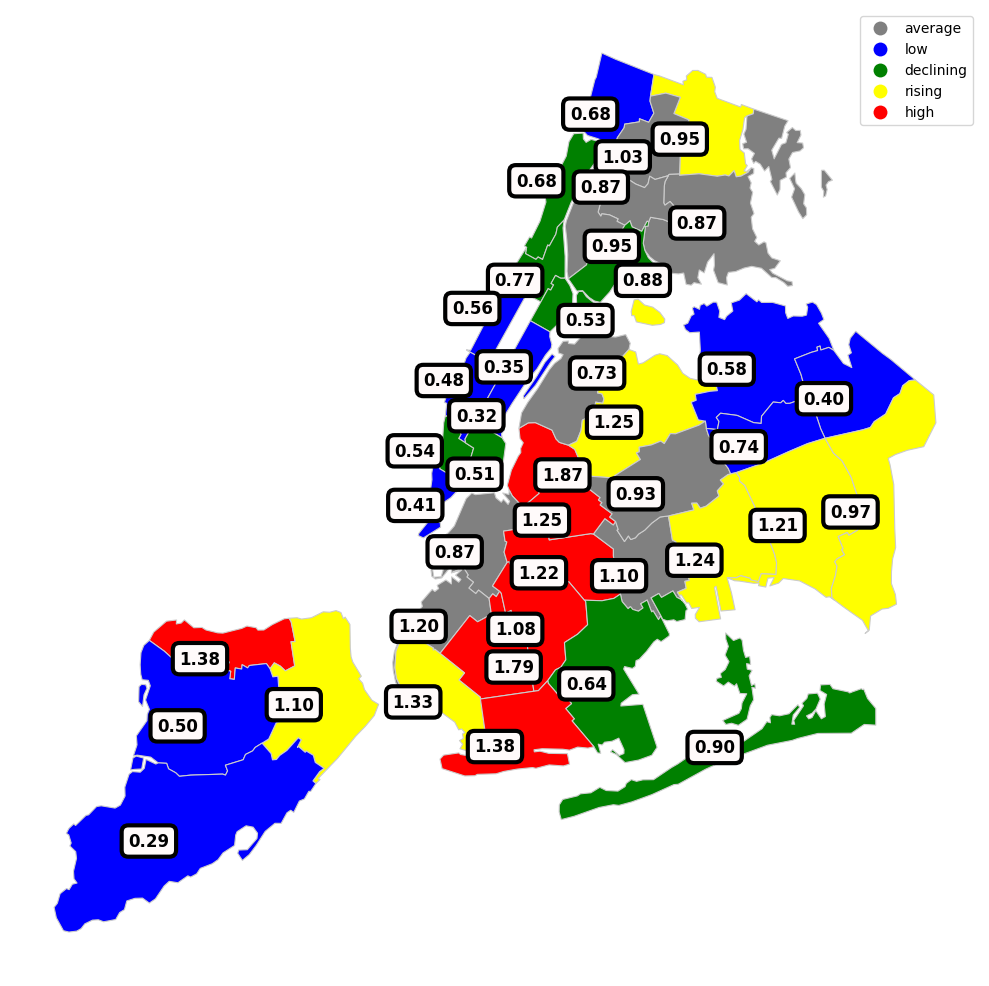

In [ ]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Create the choropleth map
fig, ax = plt.subplots(1, figsize=(10, 10))
merged_data.plot(column="Cluster", cmap=cmap, linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

# Annotate each area with the tests_ratio value, rounded to two decimal places
# We use a dictionary to map GeoID to tests_ratio for efficient lookup
tests_ratio_dict = opt_df.set_index('GeoID')['v2test/pop'].to_dict()
texts = []

for idx, row in merged_data.iterrows():
    geo_id = row['GeoID']
    tests_ratio = tests_ratio_dict.get(geo_id, '')
    if tests_ratio:
        # Round the value and convert to string for display
        tests_ratio_text = f"{tests_ratio:.2f}"

        # Create a background rectangle
        bbox_props = dict(boxstyle="round, pad=0.4", ec="black", lw=3, fc="snow")  # Adjust padding and colors as needed

        text = ax.annotate(text=tests_ratio_text,
                           xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                           horizontalalignment='center',
                           verticalalignment='center',
                           fontsize=12,  # Adjust font size as needed
                           color='black',  # Font color
                           bbox=bbox_props,  # Add the background rectangle
                           weight='bold')  # Set font weight to 'bold' for thicker numbers

        texts.append(text)

# Use adjustText to automatically adjust the positions of text labels to avoid overlap
adjust_text(texts, ax=ax, expand_text=(1.05, 1.05), force_text=(0.5, 0.5))

ax.set_title("")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("nyc_choropleth_difference_with_tests_ratio.png")
plt.show()


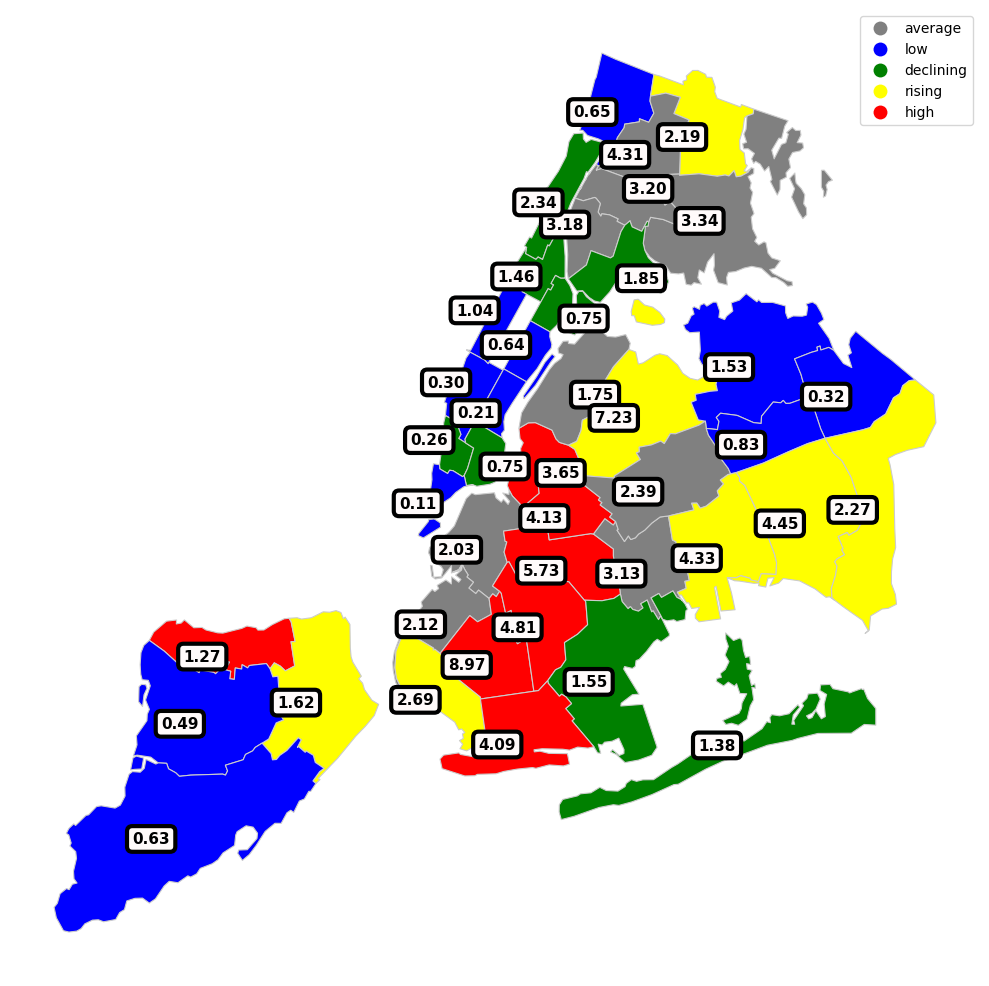

In [ ]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Create the choropleth map
fig, ax = plt.subplots(1, figsize=(10, 10))
merged_data.plot(column="Cluster", cmap=cmap, linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

# Annotate each area with the tests_ratio value, rounded to two decimal places
# We use a dictionary to map GeoID to tests_ratio for efficient lookup
tests_ratio_dict = opt_df.set_index('GeoID')['v2_tests_ratio'].to_dict()
texts = []

for idx, row in merged_data.iterrows():
    geo_id = row['GeoID']
    tests_ratio = tests_ratio_dict.get(geo_id, '')
    if tests_ratio:
        # Round the value and convert to string for display
        tests_ratio_text = f"{tests_ratio:.2f}"

        # Create a background rectangle
        bbox_props = dict(boxstyle="round, pad=0.35", ec="black", lw=3, fc="snow")  # Adjust padding and colors as needed

        text = ax.annotate(text=tests_ratio_text,
                           xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                           horizontalalignment='center',
                           verticalalignment='center',
                           fontsize=11,  # Adjust font size as needed
                           color='black',  # Font color
                           bbox=bbox_props,  # Add the background rectangle
                           weight='bold')  # Set font weight to 'bold' for thicker numbers

        texts.append(text)

# Use adjustText to automatically adjust the positions of text labels to avoid overlap
adjust_text(texts, ax=ax, expand_text=(1.05, 1.05), force_text=(0.5, 0.5))

ax.set_title("")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("nyc_choropleth_difference_with_tests_ratio.png")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming opt_df is your original DataFrame

def get_borough(geo_id):
    first_digit = int(str(geo_id)[0])
    return {
        1: 'Bronx',
        2: 'Brooklyn',
        3: 'Manhattan',
        4: 'Queens',
        5: 'Staten Island'
    }.get(first_digit, 'Unknown')

# Add a new column for borough in df_rates
borough_df = opt_df.copy()
borough_df['Borough'] = borough_df['GeoID'].apply(get_borough)

# Define the order of metrics for which to calculate percentages
metric_order = ['pop_ratio', 'tests_ratio', 'cases_ratio','diff']
label_sums_v1 = borough_df.groupby('label')[['pop_ratio', 'v1_tests_ratio', 'v1_cases_ratio','diff']].sum()
label_sums_v2 = borough_df.groupby('label')[['pop_ratio', 'v2_tests_ratio', 'v2_cases_ratio','diff']].sum()

# Calculate total sums for each metric across all labels
total_sums_v1 = label_sums_v1.sum()
total_sums_v2 = label_sums_v2.sum()

# Calculate percentages for each label for the specified metrics
label_percentages_v1 = (label_sums_v1 * 100 / total_sums_v1).reset_index()
label_percentages_v2 = (label_sums_v2 * 100 / total_sums_v2).reset_index()
#print(label_percentages_v2)

In [ ]:
# V1 data
data_v1 = {
    'label': ['average', 'low', 'declining', 'rising', 'high'],
    'v1_tests_ratio': [28.184777, 12.604456, 14.277651, 22.400494, 22.532622],
    'v1_cases_ratio': [24.895105, 5.804196, 9.685315, 25.034965, 34.580420]
}
df_v1 = pd.DataFrame(data_v1)

# V2 data
data_v2 = {
    'label': ['average', 'low', 'declining', 'rising', 'high'],
    'v2_tests_ratio': [25.465302, 6.748104, 10.347922, 24.777356, 32.661315],
    'v2_cases_ratio': [19.816514, 2.813456, 6.269113, 24.342508, 46.758410]
}
df_v2 = pd.DataFrame(data_v2)

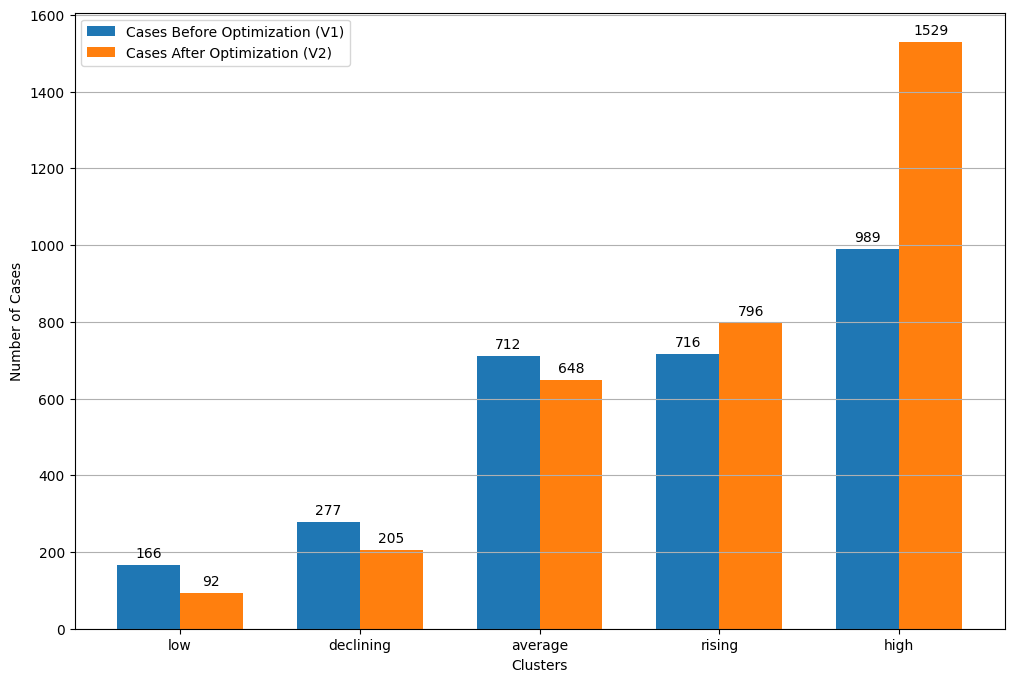

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data
data = {
    'label': ['low', 'declining', 'average', 'rising', 'high'],
    'v1_cases': [166, 277, 712, 716, 989],
    'v2_cases': [92, 205, 648, 796, 1529]
}
df = pd.DataFrame(data)

# Setting up the plot
plt.figure(figsize=(12, 8))

# X-axis positions for the groups and the width of the bars
bar_width = 0.35
x_positions = np.arange(len(df['label']))

# Plotting bars for V1 and V2 data side by side
plt.bar(x_positions - bar_width/2, df['v1_cases'], bar_width, label='Cases Before Optimization (V1)')
plt.bar(x_positions + bar_width/2, df['v2_cases'], bar_width, label='Cases After Optimization (V2)')

# Adding labels and values on top of the bars
for idx, row in df.iterrows():
    plt.text(idx - bar_width/2, row['v1_cases'] + 20, f"{row['v1_cases']}", ha='center')
    plt.text(idx + bar_width/2, row['v2_cases'] + 20, f"{row['v2_cases']}", ha='center')

# Setting labels and title
plt.xticks(x_positions, df['label'])
plt.xlabel('Clusters')
plt.ylabel('Number of Cases')
plt.title('')

plt.legend()
plt.grid(axis='y')

# Display the plot
plt.show()
